In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyaccel as pa
import pymodels as pm
from diagnostics import calc_ellipse_equation
from injection_sim import Injection

%config Completer.use_jedi = False

# Random tests/ Utils

In [2]:
bo = pm.bo.create_accelerator()
bo_et = pa.optics.calc_edwards_teng(bo)
bo_twiss = pa.optics.calc_twiss(bo)

# TEST: create_injection_lattice 

In [3]:
injsys = Injection()
injsys.create_injection_lattice()

nlk_idx = injsys._nlk_idx

print("\n Loaded Sirius Model \n",injsys._si)
print("\n Sirius start point \n",injsys._si[0])
print('\n Sirius at nlk idx \n' ,injsys._si[nlk_idx[0]])


 Loaded Sirius Model 
 energy         : 3000000000.0 eV
harmonic_number: 864
cavity_on      : True
radiation_on   : True
vchamber_on    : True
lattice size   : 6489
lattice length : 518.3898999999926 m

 Sirius start point 
 fam_name   : InjSeptF 
pass_method: identity_pass 
hmin       : -0.03 m
hmax       : 0.012 m
vmin       : -0.012 m
vmax       : 0.012 m

 Sirius at nlk idx 
 fam_name   : InjNLKckr 
pass_method: str_mpole_symplectic4_pass 
length     : 0.45 m
nr_steps   : 31 
hmin       : -0.0095 m
hmax       : 0.0095 m
vmin       : -0.012 m
vmax       : 0.012 m


# TEST: create_initial_bunch

Bunch created with  1000  particles 



/home/facs/repos/apsuite/apsuite/sirius_injection/plots.py:52: UserWarning: No contour levels were found within the data range.
  ax[1].contour(y*1e3, y_*1e3, eqy, [0], linewidths=2)


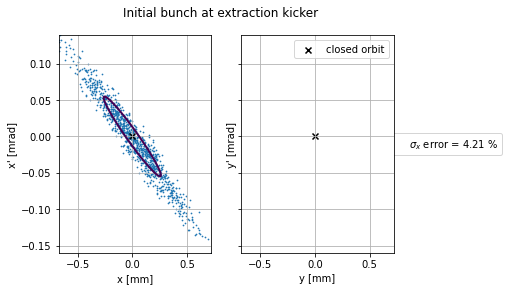

In [4]:
np.random.seed(42)
injsys.create_initial_bunch(plot=True, verbose=True)

# Test: eject_from_booster

- setting bo extraction kick to 2.461 mrad 

Particles lost at kicker to septum trajectory: 0


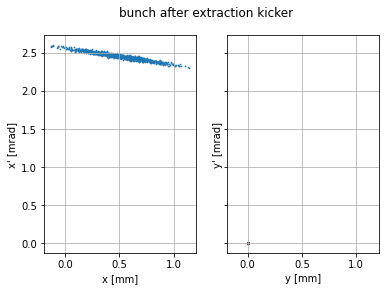

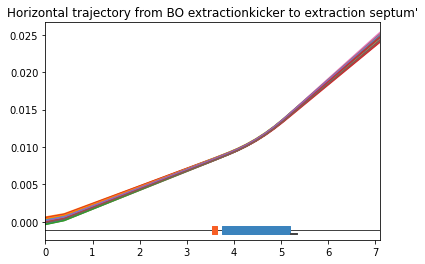

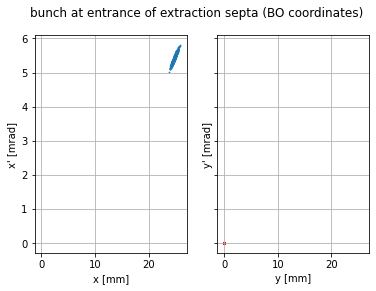

In [5]:
injsys.eject_from_booster(plot=True,verbose=True)

# Test: transport along ts

/home/facs/repos/apsuite/apsuite/sirius_injection/plots.py:51: UserWarning: No contour levels were found within the data range.
  ax[0].contour(x*1e3, x_*1e3, eqx, [0], linewidths=2)
/home/facs/repos/apsuite/apsuite/sirius_injection/plots.py:52: UserWarning: No contour levels were found within the data range.
  ax[1].contour(y*1e3, y_*1e3, eqy, [0], linewidths=2)


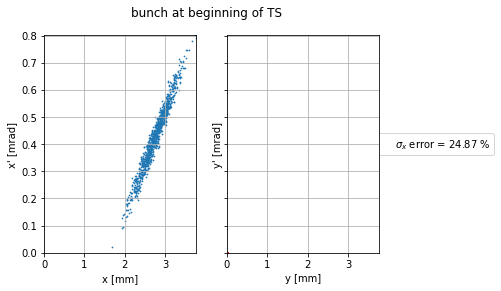

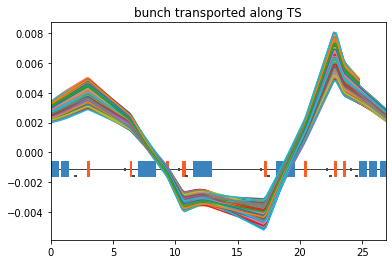

Particles losts at TS = 187


/home/facs/repos/apsuite/apsuite/sirius_injection/plots.py:51: UserWarning: No contour levels were found within the data range.
  ax[0].contour(x*1e3, x_*1e3, eqx, [0], linewidths=2)
/home/facs/repos/apsuite/apsuite/sirius_injection/plots.py:52: UserWarning: No contour levels were found within the data range.
  ax[1].contour(y*1e3, y_*1e3, eqy, [0], linewidths=2)


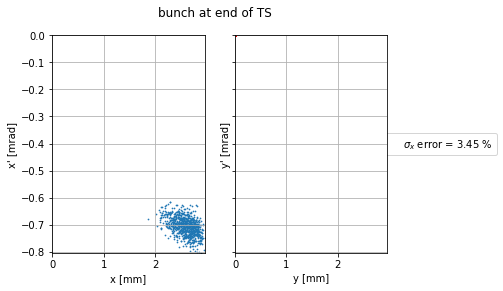

In [6]:
injsys.transport_along_ts()

In [7]:
print(injsys._bo_twiss[injsys._bo_ejesepta_idx[0]], "\n" )
print(injsys._ts_init_twiss)

spos          : +7.102e+00
rx, ry        : -6.289e-05, +0.000e+00
px, py        : +0.000e+00, +0.000e+00
de, dl        : -9.209e-05, -8.274e-02
mu1, mu2      : +2.210e+00, +4.982e-01
beta1, beta2  : +7.877e+00, +1.239e+01
alpha1, alpha2: -2.404e+00, +2.045e+00
eta1, eta2    : +0.000e+00, +0.000e+00
etap1, etap2  : +0.000e+00, +0.000e+00 

spos          : +0.000e+00
rx, ry        : +0.000e+00, +0.000e+00
px, py        : +0.000e+00, +0.000e+00
de, dl        : +0.000e+00, +0.000e+00
mux, muy      : +0.000e+00, +0.000e+00
betax, betay  : +7.906e+00, +1.184e+01
alphax, alphay: -2.423e+00, +1.880e+00
etax, etapx   : +2.114e-01, +6.939e-02
etay, etapy   : +0.000e+00, +0.000e+00


In [8]:
type(injsys._ts_init_twiss)

pyaccel.optics.twiss.Twiss

Ideia para fazer a ellipse dar certo:
spos = 0
rx, ry, px, py, de, dl transladados para as coordenadas do TS

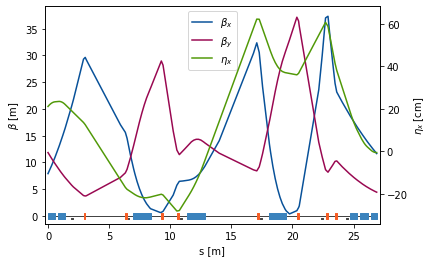

Text(0.5, 1.0, 'Default TS initial Twiss')

In [9]:
ts = injsys._ts 
twiss,_ = pa.optics.calc_twiss(ts, injsys._ts_init_twiss)
fig, ax = pa.graphics.plot_twiss(ts,twiss)
ax.set_title("Default TS initial Twiss")

Checking ideal bunch propagation

In [10]:
from diagnostics import calc_ellipse_equation
twiss = injsys._ts_twiss
eq_params = injsys._bo_eqparams
alpha = twiss.alphax[-1]
beta = twiss.betax[-1]
gamma = (1 + alpha**2)/beta 
emitx = eq_params.emit1
x,x_,eq = calc_ellipse_equation(gamma,alpha,beta,emitx,injsys._bunch[0,:], injsys._bunch[1,:])

In [11]:
np.mean(eq), np.var(eq)

(2.696358574247904e-06, 3.6551882685695915e-13)

Given a conic form $Ax^2 + Bxy + Cy^2 + F =0$ , it will be an ellipse if, and only if $B^2 - 4 A<0$. Lets check this at the end of TS

In [12]:
A = gamma
B = 2*alpha 
B**2 - 4*A

6.4291717944667255

So, for some reason, we can't form a emmitance ellipse with the twiss parameters calculated at end of Transport Line, lets try in the begining:

In [13]:
twiss = injsys._ts_twiss[0]
alpha = twiss.alphax
beta = twiss.betax
gamma = (1+ alpha**2)/beta

A = gamma
B = 2*alpha 
B**2 - 4*A


20.009098097981276

again, the same situation...

In [14]:
hmax_array = pa.lattice.get_attribute(injsys._ts, attribute_name='hmax')

In [17]:
#The physical aperture diverges at index 0 and index >= 30
hmax_array[:50]

array([0.012, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015,
       0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015,
       0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015,
       0.015, 0.015, 0.015, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012])

# Test Injection no Sirius

- beam centroid at si injpoint (rx,px)(ry,py):(+nan mm, +nan mrad) (+nan mm, +nan mrad)

Particles losts at injection point to nlk transport = 813


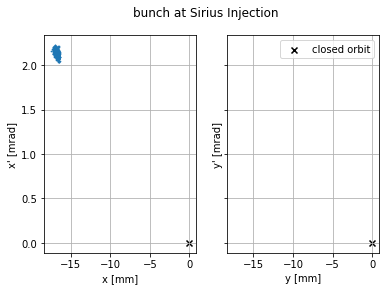

In [16]:
injsys.inject_into_si_and_transports_to_nlk()